# Lets Implement Autonomus Driving Using [End to End Learning for Self-Driving Cars](https://arxiv.org/pdf/1604.07316.pdf)  paper published by NVIDIA


<center><img src ='https://media0.giphy.com/media/H7rpSYHRyYgamxQNqw/giphy.gif?cid=ecf05e474vywyjmvuhrtnstqtjob2brfw07zhhwkksp6it7c&rid=giphy.gif&ct=g'> </center>

## Import Section

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import scipy.misc
import cv2
from subprocess import call
import math
from tensorflow.core.protobuf import saver_pb2
import skimage.transform as sktrans
import imageio
import os
import warnings
warnings.filterwarnings('ignore')


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
!nvidia-smi

Mon Jan 16 14:04:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Lets pull the data

In [4]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1JUYnkid8hqF327VGx1p1DQkNKMXomU44

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1JUYnkid8hqF327VGx1p1DQkNKMXomU44
To: /content/driving_dataset.zip
100% 2.35G/2.35G [00:09<00:00, 256MB/s]


In [5]:
!unzip /content/driving_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: driving_dataset/39754.jpg  
  inflating: __MACOSX/driving_dataset/._39754.jpg  
  inflating: driving_dataset/20211.jpg  
  inflating: __MACOSX/driving_dataset/._20211.jpg  
  inflating: driving_dataset/39998.jpg  
  inflating: __MACOSX/driving_dataset/._39998.jpg  
  inflating: driving_dataset/2695.jpg  
  inflating: __MACOSX/driving_dataset/._2695.jpg  
  inflating: driving_dataset/30002.jpg  
  inflating: __MACOSX/driving_dataset/._30002.jpg  
  inflating: driving_dataset/18956.jpg  
  inflating: __MACOSX/driving_dataset/._18956.jpg  
  inflating: driving_dataset/26660.jpg  
  inflating: __MACOSX/driving_dataset/._26660.jpg  
  inflating: driving_dataset/29553.jpg  
  inflating: __MACOSX/driving_dataset/._29553.jpg  
  inflating: driving_dataset/36473.jpg  
  inflating: __MACOSX/driving_dataset/._36473.jpg  
  inflating: driving_dataset/19490.jpg  
  inflating: __MACOSX/driving_dataset/._19490.jpg  
  inflating: driving_

In [6]:
!gdown 1m0VL0UtD-283I4a5BArBtQdlUFa4a4w4

Downloading...
From: https://drive.google.com/uc?id=1m0VL0UtD-283I4a5BArBtQdlUFa4a4w4
To: /content/steering_wheel_image.jpg
100% 55.4k/55.4k [00:00<00:00, 57.6MB/s]


## Lets create train and test batch data loaders

In [7]:
xs = []
ys = []

In [8]:
#read data.txt
with open("./driving_dataset/data.txt") as f:
    for line in f:
        xs.append("./driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

In [9]:
#get number of images
num_images = len(xs)
print("Number of images :",num_images)

Number of images : 45406


In [10]:
#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

In [11]:
train_xs = xs[:int(len(xs) * 0.8)]
train_ys = ys[:int(len(xs) * 0.8)]

val_xs = xs[-int(len(xs) * 0.2):]
val_ys = ys[-int(len(xs) * 0.2):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

In [12]:
def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(sktrans.resize(imageio.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

In [13]:
def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(sktrans.resize(imageio.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200]) / 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out

## Lets create the model as per the achitecture of NVIDIA

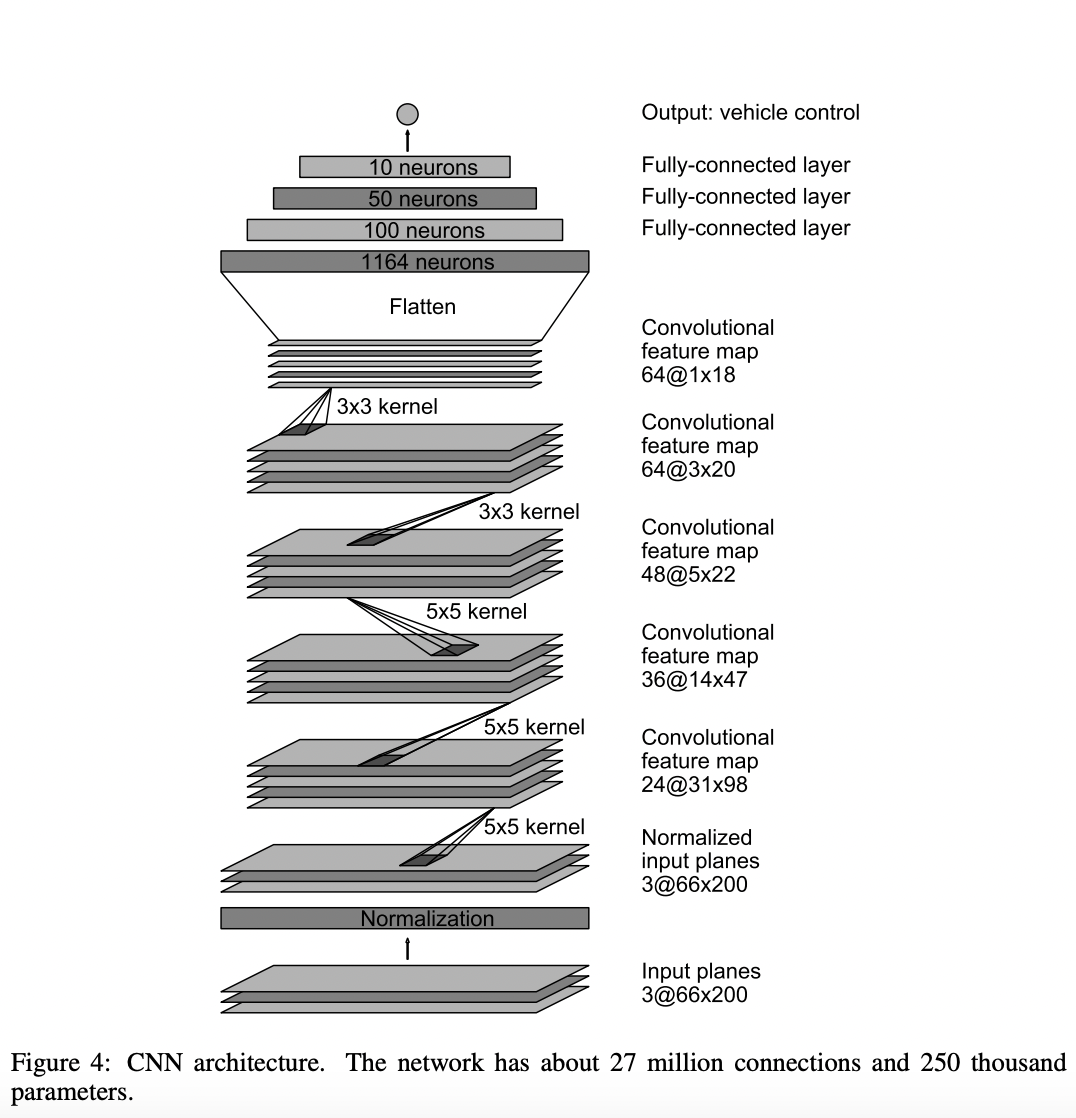

In [14]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

In [15]:
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

In [16]:
def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

In [17]:
x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 1])

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, keep_prob)

#FCL 3
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, keep_prob)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

y = tf.multiply(tf.atan(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
!mkdir save logs

mkdir: cannot create directory ‘save’: File exists
mkdir: cannot create directory ‘logs’: File exists


In [19]:
LOGDIR = './save'
sess = tf.InteractiveSession()
L2NormConst = 0.001
train_vars = tf.trainable_variables()

In [20]:
loss = tf.reduce_mean(tf.square(tf.subtract(y_, y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [21]:
# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()
saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V1)

In [22]:
# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

In [29]:
epochs = 2
batch_size = 100

## Lets Train the model

In [30]:
# train over the dataset about 30 times
for epoch in range(epochs):
  for i in range(int(num_images/batch_size)):
    xs, ys = LoadTrainBatch(batch_size)
    train_step.run(feed_dict={x: xs, y_: ys, keep_prob: 0.8})
    if i % 10 == 0:
      xs, ys = LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={x:xs, y_: ys, keep_prob: 1.0})
    summary_writer.add_summary(summary, epoch * num_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model.ckpt")
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

Epoch: 0, Step: 0, Loss: 0.225016
Epoch: 0, Step: 10, Loss: 0.517007
Epoch: 0, Step: 20, Loss: 0.219572
Epoch: 0, Step: 30, Loss: 0.152583
Epoch: 0, Step: 40, Loss: 0.13176
Epoch: 0, Step: 50, Loss: 0.164686
Epoch: 0, Step: 60, Loss: 0.30926
Epoch: 0, Step: 70, Loss: 1.11741
Epoch: 0, Step: 80, Loss: 1.80252
Epoch: 0, Step: 90, Loss: 0.356423
Epoch: 0, Step: 100, Loss: 0.202765
Epoch: 0, Step: 110, Loss: 0.118634
Epoch: 0, Step: 120, Loss: 0.123007
Epoch: 0, Step: 130, Loss: 0.12091
Epoch: 0, Step: 140, Loss: 0.131689
Epoch: 0, Step: 150, Loss: 0.153415
Epoch: 0, Step: 160, Loss: 0.153366
Epoch: 0, Step: 170, Loss: 0.120105
Epoch: 0, Step: 180, Loss: 0.255608
Epoch: 0, Step: 190, Loss: 0.530262
Epoch: 0, Step: 200, Loss: 0.225337
Epoch: 0, Step: 210, Loss: 0.302052
Epoch: 0, Step: 220, Loss: 0.133576
Epoch: 0, Step: 230, Loss: 0.133978
Epoch: 0, Step: 240, Loss: 0.133629
Epoch: 0, Step: 250, Loss: 0.132824
Epoch: 0, Step: 260, Loss: 0.145154
Epoch: 0, Step: 270, Loss: 4.64633
Epoch: 0,

In [24]:
!gdown 1-mJ8G603XbrC43oNTLM78fSCCcB8Lf8U

Downloading...
From: https://drive.google.com/uc?id=1-mJ8G603XbrC43oNTLM78fSCCcB8Lf8U
To: /content/model.ckpt
100% 19.2M/19.2M [00:00<00:00, 170MB/s]


## Lets test the prediction

In [25]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "/content/model.ckpt")

img = cv2.imread('steering_wheel_image.jpg',0)
rows,cols = img.shape

smoothed_angle = 0.01

In [26]:
#read data.txt
xs = []
ys = []
with open("driving_dataset/data.txt") as f:
    for line in f:
        xs.append("driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


i = math.ceil(num_images*0.8)
print("Starting frameofvideo:" +str(i))

Starting frameofvideo:36325


In [27]:
from google.colab.patches import cv2_imshow

In [28]:
count = 0
while(cv2.waitKey(10) != ord('q')):
    full_image = imageio.imread("driving_dataset/" + str(i) + ".jpg")
    image = sktrans.resize(full_image[-150:], [66, 200]) / 255.0
    degrees = y.eval(feed_dict={x: [image], keep_prob: 1.0})[0][0] * 180.0 / scipy.pi
    #call("clear")
    #print("Predicted Steering angle: " + str(degrees))
    #print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]*180/scipy.pi) + " (actual)")
    print("*"*100)
    cv2_imshow(cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    cv2_imshow(dst)
    i += 1
    count+=1
    if count == 100:
      break

cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.